In [1]:
!pip3 install parsivar
!pip install nltk==3.2.2
!pip install clean_text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 39.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for nltk: filename=nltk-3.2.2-py3-none-any.whl size=1353248 sha256=8184ab96a80713e07b0b9e34c08aeb67523b96125b6427e54bcf83a671482fe2
  Stored in directory: /root/.cache/pip/wheels/ba/64/d0/28a3b1b1914873a93b118ee166980a98823eadf0616070700a
Successfully built nltk
  Attempting uninstall: nltk
    Found existing installation: nltk 3.8.1
    Uninstalling nltk-3.8.1:
      Successfully uninstalled nltk-3.8.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
parsivar 0.2.3.1 requires nltk>=3.6.6, but you have nltk 3.2.2 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.4/175.4 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ..

In [25]:
from parsivar import Tokenizer , Normalizer
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import re
from cleantext import clean
from torch import cuda
from parsivar import Tokenizer
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
import transformers
from transformers import DistilBertTokenizer, DistilBertModel, BertConfig, BertTokenizer
from sklearn import metrics
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, accuracy_score
import warnings
import logging

In [3]:
normalizer = Normalizer(statistical_space_correction=True)
tokenizer = Tokenizer()

def cleanhtml(raw_html):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', raw_html)
    return cleantext

def cleaning(text):
    text = text.strip()

    # regular cleaning
    text = clean(text,
        fix_unicode=True,
        to_ascii=False,
        lower=True,
        no_line_breaks=True,
        no_urls=True,
        no_emails=True,
        no_phone_numbers=True,
        no_numbers=False,
        no_digits=False,
        no_currency_symbols=True,
        no_punct=False,
        replace_with_url="",
        replace_with_email="",
        replace_with_phone_number="",
        replace_with_number="",
        replace_with_digit="0",
        replace_with_currency_symbol="",
    )
    # cleaning htmls
    text = cleanhtml(text)

    text = normalizer.normalize(text)

    # removing wierd patterns
    wierd_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u'\U00010000-\U0010ffff'
        u"\u200d"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\u3030"
        u"\ufe0f"
        u"\u2069"
        u"\u2066"
        u"\u2068"
        u"\u2067"
        "]+", flags=re.UNICODE)
    text = wierd_pattern.sub(r'', text)
    text = re.sub("#", "", text)
    text = re.sub("\s+", " ", text)
    return text

In [5]:
# train data
df = pd.read_csv('/content/train.tsv',sep='\t' , names=['text', 'labels'])
df.head()

,text,labels
0,خیلی کوچیک هستن و سایزشون بدرد نمیخوره میخوام ...,SAD
1,از صدای پرنده دم دمای صبح متنفرم متنفرم متنفرم,HATE
2,"""کیفیتش خیلی خوبه با شک خریدم ولی واقعا راضیم...",SAD
3,چون همش با دوربین ثبت شده ، ایا میشه اعتراض زد...,OTHER
4,اين وضع ب طرز خنده داري گريه داره ...,SAD


In [6]:
df['text'] = df['text'].apply(cleaning)
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,text,labels
0,چرا آخه ؟,SURPRISE
1,با‌اینکه ، ممنوعه‌ترینی‌ ...! با‌اینکه ، در حو...,SAD
2,این حجم از خشم و نفرت در من نمیگنجه الان,ANGRY
3,اخ گفتی,OTHER
4,به به چه هوایی ، عجب صورت ماهی,HAPPY


In [7]:
# test data
df_test = pd.read_csv('/content/test.tsv',sep='\t' , names=['text', 'labels'])
df_test.head()

,text,labels
0,اين شايد اولين عزاى عمومى واقعى است كه ياد دار...,SAD
1,دیشب بعد از ارسال تویت مربوط به آثار باستانی ت...,HAPPY
2,کدوم شعبه پول نداده، بگو الان برات آمار دقیق ...,OTHER
3,امروز وسط یه بحث با بابا مامانم گفتم آدم باید ...,HAPPY
4,امشب گفت نامزدی دوستش که ادم روشنفکری است بهم ...,SAD


In [8]:
df_test['text'] = df_test['text'].apply(cleaning)
df_test = df.sample(frac=1).reset_index(drop=True)
df_test.head()

,text,labels
0,انتصابی و انتخابی تفاوتی ندارن ، مردم فکر می‌ک...,ANGRY
1,بی ادب,ANGRY
2,"یه دوستی تو‌بیوی‌تلگرامش نوشته "" ‌های درود ""! ...",OTHER
3,: داستان ترسناک الو از نیروی انتظامی تماس می‌...,FEAR
4,به دلیل حبس بودنم تو اون وضعیت از هر‌اهنگی که ...,HATE


In [9]:
def one_hot_encoder(df):
  for index, row in df.iterrows():
    if row["labels"] =="ANGRY":
        row["labels"]=[0, 0, 0, 0, 0, 0, 1]
    elif row["labels"] =="FEAR":
        row["labels"]=[0, 0, 0, 0, 0, 1, 0]
    elif row["labels"] =="HAPPY":
        row["labels"]=[0, 0, 0, 0, 1, 0, 0]
    elif row["labels"] =="HATE":
        row["labels"]=[0, 0, 0, 1, 0, 0, 0]
    elif row["labels"] =="SAD":
        row["labels"]=[0, 0, 1, 0, 0, 0, 0]
    elif row["labels"] =="SURPRISE":
        row["labels"]=[0, 1, 0, 0, 0, 0, 0]
    elif row["labels"] =="OTHER":
        row["labels"]=[1, 0, 0, 0, 0, 0, 0]

In [10]:
categories = ["ANGRY", "FEAR", "HAPPY", "HATE", "SAD", "SURPRISE","OTHER"]

# Convert emotion labels to numerical format (one-hot encoding)
one_hot_encoder(df)
one_hot_encoder(df_test)

In [11]:
df.head()

,text,labels
0,چرا آخه ؟,"[0, 1, 0, 0, 0, 0, 0]"
1,با‌اینکه ، ممنوعه‌ترینی‌ ...! با‌اینکه ، در حو...,"[0, 0, 1, 0, 0, 0, 0]"
2,این حجم از خشم و نفرت در من نمیگنجه الان,"[0, 0, 0, 0, 0, 0, 1]"
3,اخ گفتی,"[1, 0, 0, 0, 0, 0, 0]"
4,به به چه هوایی ، عجب صورت ماهی,"[0, 0, 0, 0, 1, 0, 0]"


In [12]:
df_test.head()

,text,labels
0,انتصابی و انتخابی تفاوتی ندارن ، مردم فکر می‌ک...,"[0, 0, 0, 0, 0, 0, 1]"
1,بی ادب,"[0, 0, 0, 0, 0, 0, 1]"
2,"یه دوستی تو‌بیوی‌تلگرامش نوشته "" ‌های درود ""! ...","[1, 0, 0, 0, 0, 0, 0]"
3,: داستان ترسناک الو از نیروی انتظامی تماس می‌...,"[0, 0, 0, 0, 0, 1, 0]"
4,به دلیل حبس بودنم تو اون وضعیت از هر‌اهنگی که ...,"[0, 0, 0, 1, 0, 0, 0]"


In [13]:
device = 'cuda' if cuda.is_available() else 'cpu'
print(f"Device is {device}")

Device is cuda


In [14]:
MAX_LEN=256
BATCH_SIZE = 8
EPOCHS = 8
LEARNING_RATE = 2e-05
MODEL_NAME_OR_PATH = 'HooshvareLab/bert-fa-base-uncased'
OUTPUT_PATH = '/content/SA/pytorch_model.bin'

os.makedirs(os.path.dirname(OUTPUT_PATH), exist_ok=True)

In [15]:
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME_OR_PATH)

vocab.txt:   0%|          | 0.00/1.20M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/440 [00:00<?, ?B/s]

In [16]:
class MultiLabelDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.text
        self.targets = dataframe.labels
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }


In [17]:
print("TRAIN Dataset: {}".format(df.shape))
print("TEST Dataset: {}".format(df_test.shape))

training_set = MultiLabelDataset(df, tokenizer, MAX_LEN)
test_set = MultiLabelDataset(df_test, tokenizer, MAX_LEN)

TRAIN Dataset: (6125, 2)
TEST Dataset: (6125, 2)


In [18]:
train_params = {'batch_size': BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': BATCH_SIZE,
                'shuffle': False,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(test_set, **test_params)

In [19]:
from transformers import BertModel

class ParsBertModel(torch.nn.Module):
    def __init__(self):
        super(ParsBertModel, self).__init__()
        self.l1 = DistilBertModel.from_pretrained(MODEL_NAME_OR_PATH)
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.1)
        self.classifier = torch.nn.Linear(768, 7)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.Tanh()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

model = ParsBertModel()
model.to(device)

You are using a model of type bert to instantiate a model of type distilbert. This is not supported for all configurations of models and can yield errors.


pytorch_model.bin:   0%|          | 0.00/654M [00:00<?, ?B/s]

Some weights of DistilBertModel were not initialized from the model checkpoint at HooshvareLab/bert-fa-base-uncased and are newly initialized: ['transformer.layer.1.output_layer_norm.bias', 'transformer.layer.6.attention.q_lin.weight', 'transformer.layer.2.attention.k_lin.bias', 'transformer.layer.5.ffn.lin2.bias', 'transformer.layer.6.ffn.lin2.bias', 'transformer.layer.2.attention.k_lin.weight', 'transformer.layer.11.sa_layer_norm.bias', 'transformer.layer.7.ffn.lin2.weight', 'transformer.layer.1.attention.v_lin.bias', 'transformer.layer.7.sa_layer_norm.weight', 'transformer.layer.1.attention.k_lin.bias', 'transformer.layer.0.attention.v_lin.bias', 'transformer.layer.2.ffn.lin2.bias', 'transformer.layer.3.ffn.lin1.weight', 'transformer.layer.4.sa_layer_norm.weight', 'transformer.layer.8.sa_layer_norm.bias', 'transformer.layer.11.sa_layer_norm.weight', 'transformer.layer.5.attention.v_lin.weight', 'transformer.layer.11.ffn.lin2.weight', 'transformer.layer.10.attention.v_lin.weight', 't

ParsBertModel(
  (l1): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(100000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-11): 12 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(i

In [20]:
import torch , gc
torch.cuda.empty_cache()
gc.collect()
pt_model = None

!nvidia-smi

Thu Feb  1 16:26:34 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0              27W /  70W |    779MiB / 15360MiB |      2%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [21]:
def loss_fn(outputs, targets):
    return torch.nn.CrossEntropyLoss()(outputs, targets)

In [22]:
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

In [23]:
def train(epoch):
    model.train()
    for _,data in tqdm(enumerate(training_loader, 0)):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        outputs = model(ids, mask, token_type_ids)

        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)
        last_loss = loss.item()

        loss.backward()
        optimizer.step()
    print(f'Epoch: {epoch}, Loss:  {last_loss}')

In [24]:
for epoch in range(EPOCHS):
    train(epoch)

0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
766it [04:46,  2.67it/s]


Epoch: 0, Loss:  2.0181758403778076


766it [04:50,  2.64it/s]


Epoch: 1, Loss:  1.0008939504623413


766it [04:50,  2.64it/s]


Epoch: 2, Loss:  0.47823768854141235


766it [04:50,  2.64it/s]


Epoch: 3, Loss:  0.41196465492248535


766it [04:50,  2.64it/s]


Epoch: 4, Loss:  0.24265031516551971


766it [04:49,  2.64it/s]


Epoch: 5, Loss:  0.05036584287881851


766it [04:49,  2.64it/s]


Epoch: 6, Loss:  0.48148465156555176


766it [04:49,  2.64it/s]

Epoch: 7, Loss:  0.44783639907836914


In [26]:
def test(testing_loader):
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for _, data in tqdm(enumerate(testing_loader, 0)):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets

In [27]:
outputs, targets = test(testing_loader)

766it [01:43,  7.42it/s]


In [29]:
def class_finder(outputs):
  final_outputs= np.zeros_like(outputs)
  for i in range(len(outputs)):
    index=np.argmax(outputs[i])
    final_outputs[i][index]=1
  return final_outputs

In [30]:
final_outputs = class_finder(outputs)

In [31]:
other_final_outputs = [i[0] for i in final_outputs]
surprised_final_outputs = [i[1] for i in final_outputs]
sad_final_outputs = [i[2] for i in final_outputs]
hate_final_outputs = [i[3] for i in final_outputs]
happy_final_outputs = [i[4] for i in final_outputs]
fear_final_outputs = [i[5] for i in final_outputs]
angry_final_outputs = [i[6] for i in final_outputs]

other_targets = [i[0] for i in targets]
surprised_targets = [i[1] for i in targets]
sad_targets = [i[2] for i in targets]
hate_targets = [i[3] for i in targets]
happy_targets = [i[4] for i in targets]
fear_targets = [i[5] for i in targets]
angry_targets = [i[6] for i in targets]

In [32]:
label_finals = [angry_final_outputs, fear_final_outputs, happy_final_outputs, hate_final_outputs, sad_final_outputs, surprised_final_outputs, angry_final_outputs]
label_targets = [angry_targets, fear_targets, happy_targets, hate_targets, sad_targets, surprised_targets, angry_targets]
label = ["ANGRY", "FEAR", "HAPPY", "HATE", "SAD", "SURPRISE","OTHER"]

total_acc = 0
confusion_matrices = {}


for i in range(len(label)):
  accuracy = accuracy_score(label_targets[i], label_finals[i])
  total_acc += accuracy
  print(f"Accuracy for {label[i]}: {accuracy}")
  print(f"Precision for {label[i]}: {precision_score(label_targets[i], label_finals[i])}")
  print(f"Recall for {label[i]}: {recall_score(label_targets[i], label_finals[i])}")
  print(f"F1 for {label[i]}: {f1_score(label_targets[i], label_finals[i])}")

  # Confusion Matrix
  cm = confusion_matrix(label_targets[i], label_finals[i])
  confusion_matrices[label[i]] = cm
  print(f"Confusion Matrix for {label[i]}:\n{cm}")

  print("\n ------------------------------------------------------------- \n")

total_acc /= 7
print(f"Total accuracy is {total_acc}")

Accuracy for ANGRY: 0.9936326530612245
Precision for ANGRY: 0.9742489270386266
Recall for ANGRY: 0.9837486457204767
F1 for ANGRY: 0.9789757412398922
Confusion Matrix for ANGRY:
[[5178   24]
 [  15  908]]

 ------------------------------------------------------------- 

Accuracy for FEAR: 0.9957551020408163
Precision for FEAR: 0.9959294436906377
Recall for FEAR: 0.9696169088507266
F1 for FEAR: 0.9825970548862115
Confusion Matrix for FEAR:
[[5365    3]
 [  23  734]]

 ------------------------------------------------------------- 

Accuracy for HAPPY: 0.9951020408163266
Precision for HAPPY: 0.9932885906040269
Recall for HAPPY: 0.9579288025889967
F1 for HAPPY: 0.9752883031301481
Confusion Matrix for HAPPY:
[[5503    4]
 [  26  592]]

 ------------------------------------------------------------- 

Accuracy for HATE: 0.9898775510204082
Precision for HATE: 0.9149722735674677
Recall for HATE: 0.9686888454011742
F1 for HATE: 0.94106463878327
Confusion Matrix for HATE:
[[5568   46]
 [  16  495]

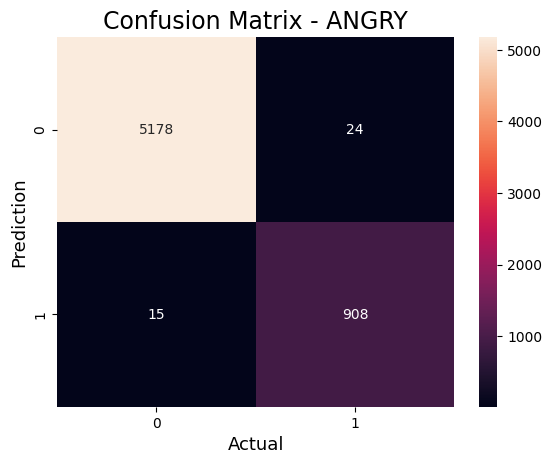

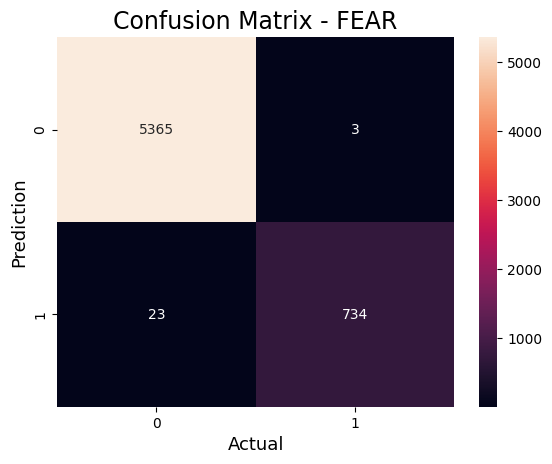

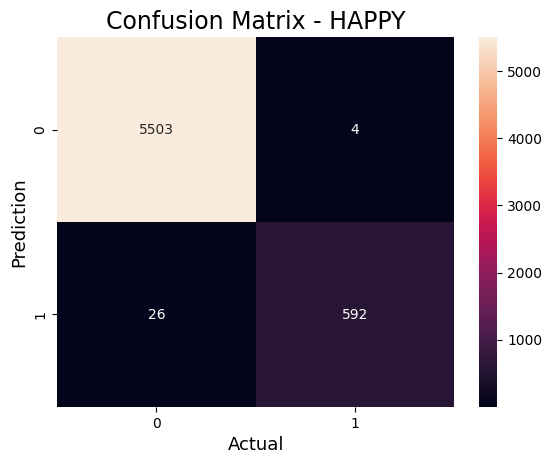

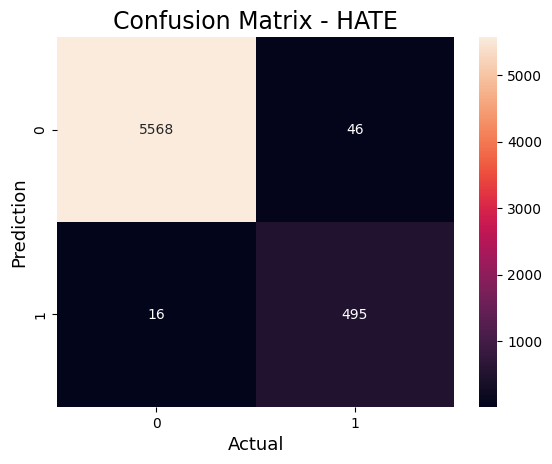

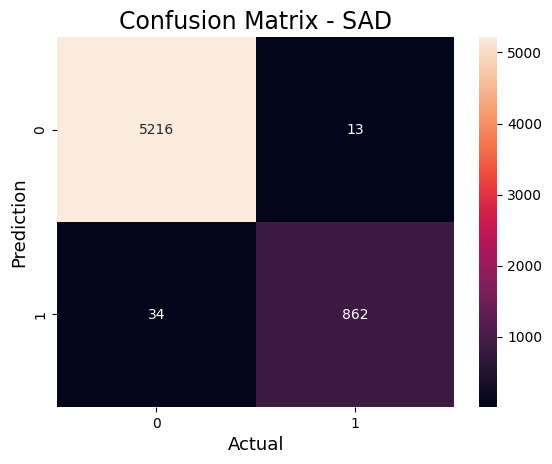

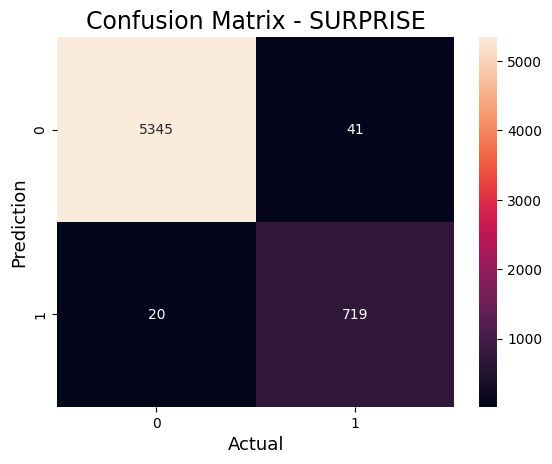

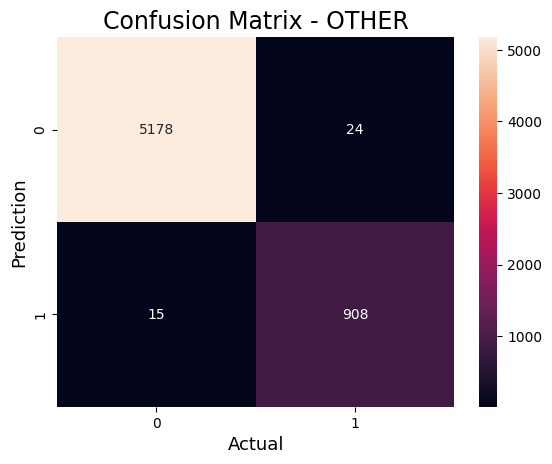

In [33]:
# Plot all Confusion Matrices
for lbl, cm in confusion_matrices.items():
    sns.heatmap(cm, annot=True, fmt='g')
    plt.ylabel('Prediction', fontsize=13)
    plt.xlabel('Actual', fontsize=13)
    plt.title(f'Confusion Matrix - {lbl}', fontsize=17)
    plt.savefig(f'confusion_matrix_{lbl}.png')  # Save the confusion matrix plot as an image
    plt.show()

#Test 5 sentences

In [45]:
df_rnd_test = df_test.sample(n=5).reset_index(drop=True)
df_rnd_test.head()

,text,labels
0,قانون منع بکار‌گیری بازنشستگان شهرداران را معا...,"[0, 0, 0, 0, 0, 0, 1]"
1,خیلی با دقت هم دنبال می‌کنید,"[1, 0, 0, 0, 0, 0, 0]"
2,دو روز به سالگرد ازدواجمون‌مونده و با رسیدن ای...,"[0, 0, 0, 0, 1, 0, 0]"
3,اینقدر بدم ازن با حجاب اسلامی میاد نمی‌دونم چرا,"[0, 0, 0, 1, 0, 0, 0]"
4,اینقدر که حال و هوای قبرستان بهم‌میچسبه شادی و...,"[0, 0, 1, 0, 0, 0, 0]"


In [46]:
test_rnd_params = {'batch_size': 1,
                'shuffle': False,
                'num_workers': 0
                }

test_rnd_set = MultiLabelDataset(df_rnd_test, tokenizer, MAX_LEN)
testing_rnd_loader = DataLoader(test_rnd_set, **test_rnd_params)

outputs, targets = test(testing_rnd_loader)

5it [00:00, 23.90it/s]


In [47]:
def one_hot_to_string(one_hot):
    if  one_hot == [0, 0, 0, 0, 0, 0, 1]:
        return "ANGRY"
    elif one_hot == [0, 0, 0, 0, 0, 1, 0]:
        return "FEAR"
    elif one_hot == [0, 0, 0, 0, 1, 0, 0]:
        return "HAPPY"
    elif one_hot == [0, 0, 0, 1, 0, 0, 0]:
        return "HATE"
    elif one_hot == [0, 0, 1, 0, 0, 0, 0]:
        return "SAD"
    elif one_hot == [0, 1, 0, 0, 0, 0, 0]:
        return "SURPRISE"
    elif one_hot == [1, 0, 0, 0, 0, 0, 0]:
        return "OTHER"

In [49]:
final_outputs_rnd = class_finder(outputs)

for ind in df_rnd_test.index:
    print(f"The text is :{df_rnd_test['text'][ind]}")
    print(f"The True Label is : {one_hot_to_string(df_rnd_test['labels'][ind])}")
    print(f"The Predicted label is {one_hot_to_string(list(final_outputs_rnd[ind]))}")

The text is :قانون منع بکار‌گیری بازنشستگان شهرداران را معاف کرده ! این قانونگذاری مملکت خراب شده ما خیلی عجیبه ! یه قانون تصویب‌میشه‌بعدیه تبصره میزنن قانون رو نفی میکنه . مثل این میمونه‌که بگن طبق قانون دزدی کار غیرقانونی است ولی تبصره معافیت از این قانون برای فقرا میاد . مجلس _ بی _ عرضه
The True Label is : ANGRY
The Predicted label is ANGRY
The text is :خیلی با دقت هم دنبال می‌کنید
The True Label is : OTHER
The Predicted label is OTHER
The text is :دو روز به سالگرد ازدواجمون‌مونده و با رسیدن این کارت ، شور و هیجانی که سال پیش با ورق خوردن تقویم و رسیدن به مراسم ازدواجمون داشتم رو دوباره حس کردم . ‌قراره به عنوان ساقدوش در کنار دو دوست همجنسگرایی که توی شادی و غم‌کنارمون بودن حاضر بشیم . امیدوارم همه این حس رو تجربه‌کنن رامینیما
The True Label is : HAPPY
The Predicted label is HAPPY
The text is :اینقدر بدم ازن با حجاب اسلامی میاد نمی‌دونم چرا
The True Label is : HATE
The Predicted label is HATE
The text is :اینقدر که حال و هوای قبرستان بهم‌میچسبه شادی و ... بهم‌نمیچسبه‌ !!! ‌حال و ه

In [91]:
#from .  import model  , one_hot_to_string
def predict(text):
  tokenizer = BertTokenizer.from_pretrained('HooshvareLab/bert-fa-base-uncased')
  MAX_LEN=256
  df= pd.DataFrame([text], columns=['text'])
  inputs = tokenizer.encode_plus(
      text,
      None,
      add_special_tokens=True,
      max_length= MAX_LEN,
      pad_to_max_length=True,
      return_token_type_ids=True
  )

  ids = torch.tensor(inputs['input_ids'], dtype=torch.long).unsqueeze(0).to(device, dtype = torch.long)
  mask = torch.tensor(inputs['attention_mask'], dtype=torch.long).unsqueeze(0).to(device, dtype = torch.long)
  token_type_ids = torch.tensor(inputs["token_type_ids"], dtype=torch.long).unsqueeze(0).to(device, dtype = torch.long)

  with torch.no_grad():
    outputs = model(ids, mask, token_type_ids)
  probabilities = torch.sigmoid(outputs).squeeze().tolist()
  final_output = [0,0,0,0,0,0,0]
  index=np.argmax(probabilities)
  final_output[index] = 1
  print(f"the text is: {text}")
  print(f"the label is: {one_hot_to_string(list(final_output))}")


a = predict("من  امروز رفتم مدرسه و برف بازی کردم و خیلی روز خوبی بود")


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


the text is: من  امروز رفتم مدرسه و برف بازی کردم و خیلی روز خوبی بود
the label is: HAPPY
